Requirements (the Captchanet library is **not required** to run inference):
- Python 3.7
- `tensorflow >= 2.0`: to load and execute the model.
- `numpy`: you know...
- `tqdm`: a progress bar.
- `matplotlib`: to plot things.
- `requests`: to download stuff on the internet.
- `pillow`: to convert a raw string to an image array.

In [12]:
# Use this to disable GPU.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

from pathlib import Path
import urllib
import tempfile
import os
import zipfile
import io

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import requests
import tqdm
from tqdm.auto import trange


# Useful functions.

class _TqdmUpTo(tqdm.tqdm):
  """Alternative Class-based version of the above.
  Provides `update_to(n)` which uses `tqdm.update(delta_n)`.
  Inspired by [twine#242](https://github.com/pypa/twine/pull/242),
  [here](https://github.com/pypa/twine/commit/42e55e06).
  """

  def update_to(self, b=1, bsize=1, tsize=None):
    """
    Args:
        b: int, optional
            Number of blocks transferred so far [default: 1].
        bsize: int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize: int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
    """
    if tsize is not None:
      self.total = tsize
    self.update(b * bsize - self.n)  # will also set self.n = b * bsize


def download_zip(zip_url, extract_folder_path, progressbar=True):
  """Download a ZIP file from an URL and extract to a given local folder.

  Args:
      zip_url: The URL to the ZIP file as a str.
      extract_folder_path: The path to the local folder for the extraction.
  """
  temp_path = tempfile.mktemp(suffix=".zip")

  with _TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, disable=not progressbar) as t:
    urllib.request.urlretrieve(zip_url, filename=temp_path, reporthook=t.update_to, data=None)

  with zipfile.ZipFile(temp_path) as zf:
    zf.extractall(extract_folder_path)

  os.remove(temp_path)

### Get the captchanet model

In [2]:
# Here we use a temporary folder to store the model but any other folder work.
model_path = Path(tempfile.mkdtemp())

# Download the model to `model_path`.
model_url = "https://storage.googleapis.com/hadim-data/models/captchanet-rip-v5.zip"
download_zip(model_url, model_path)

19.3MB [00:00, 59.2MB/s]                            


### Load the model

In [ ]:
# Load the tokenizer used to convert (vector of integers to list of letters).
# The tokenizer could/should be embedded in the model in the future.
with open(model_path / 'tokenizer.json') as f:
  #tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(f.read())
  from keras_preprocessing import text
  tokenizer = text.tokenizer_from_json(f.read())
  
# Load the model in memory
model = tf.keras.models.load_model(str(model_path / 'model'))

### Get images

In [13]:
# Download some captcha images
batch_size = 8
captcha_url = "https://www.referendum.interieur.gouv.fr/bundles/ripconsultation/securimage/securimage_show.php"
images = [np.array(Image.open(io.BytesIO(requests.get(captcha_url).content))) for _ in trange(batch_size)]
images = np.array(images)

# `images` has the shape: [BATCH, WIDTH, HEIGHT, CHANNEL]

### Preproces images

In [14]:
# The images need to be normalized t [0, 1] and resize to (224, 224).
image_size = (224, 224)
batch = tf.cast(images, 'float32')
batch = tf.image.per_image_standardization(batch)
batch = tf.image.resize(batch, image_size)

W0712 22:55:26.440796 140705471682368 deprecation.py:323] From /home/hadim/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Solve captcha

In [15]:
# Here we run the model
labels = model(batch)

NameError: name 'model' is not defined

### Postprocess the labels

In [ ]:
# Decode the predicted labels to words.
labels = tf.argmax(labels, axis=2)
words = [tokenizer.sequences_to_texts([label])[0] for label in labels]
words = [word.replace(' ', '') for word in words]
words

### Display the result

NameError: name 'words' is not defined

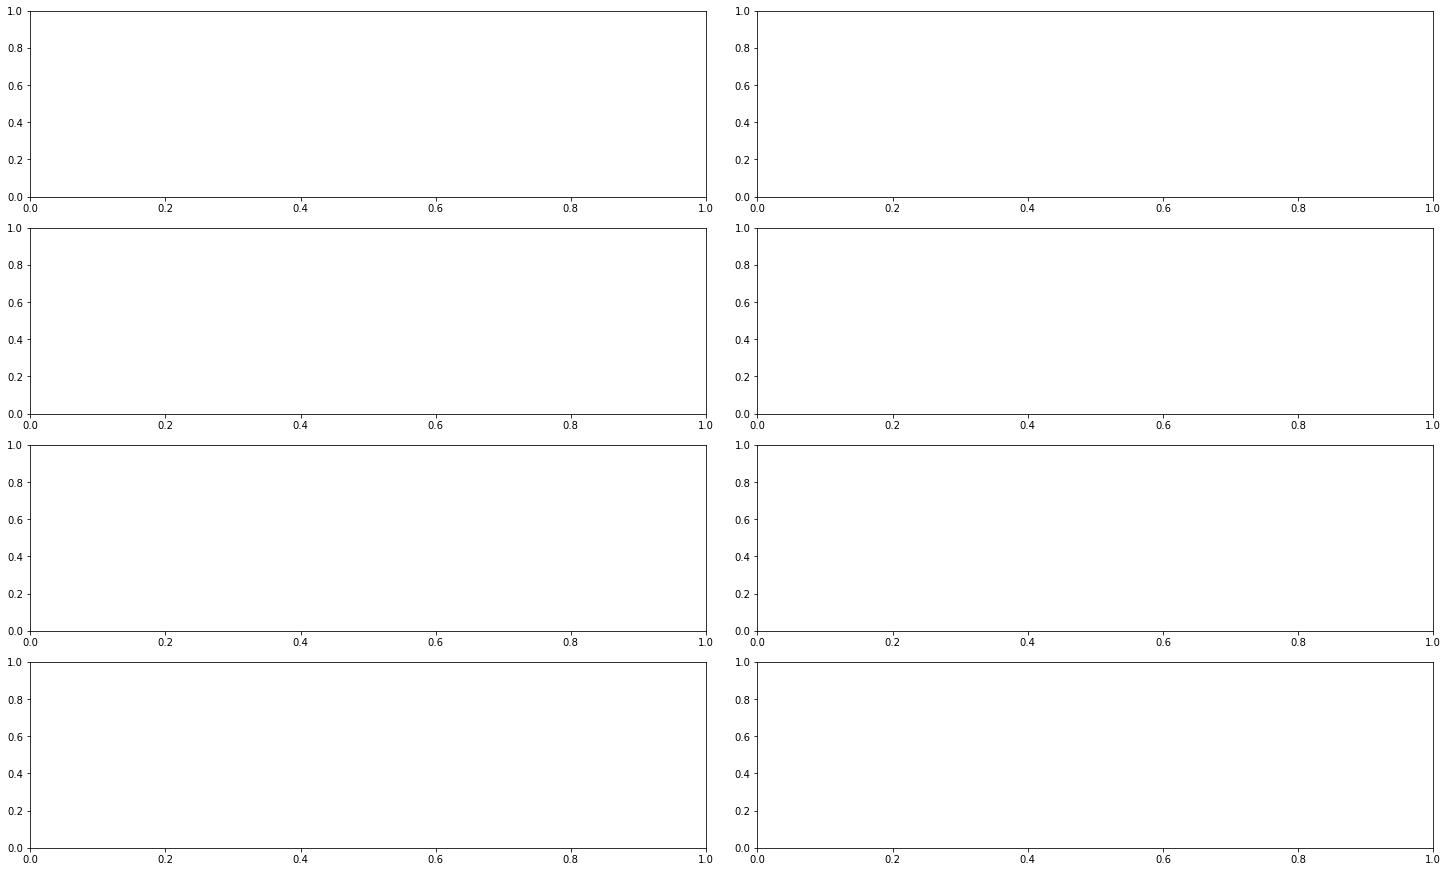

In [17]:
# Plot the images with the predicted words.
size = 3
ncols = 2
nrows = batch_size // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, ax in zip(images, words, axs):
  ax.imshow(image)
  text = f'Predicted word: {word} ({len(word)})'
  ax.set_title(text)